In [1]:
from boilerplate import *

In [3]:
dataset = get_data("quac")

Dataset quac downloaded and prepared to /root/.cache/huggingface/datasets/quac/plain_text/1.1.0/4170258e7e72d7c81bd6441b3f3489ea1544f0ff226ce61e22bb00c6e9d01fb6. Subsequent calls will reuse this data.


In [4]:
df = data_to_dataframe(dataset)

In [5]:
training = df[2]
training.head(2)

,source,target
0,"According to the Indian census of 2001, there ...","[Where is Malayali located?, What other langua..."
1,Malayalam is the language spoken by the Malaya...,"[what language do they speak?, Do they speak a..."


In [1]:
# Commenting out to remove the output
# !pip install bertopic[all]

In [8]:
from bertopic import BERTopic

In [9]:
unique_contexts = training["source"].unique()

In [10]:
topic_model = BERTopic(language="english", calculate_probabilities=True)
topics, probabilities = topic_model.fit_transform(unique_contexts)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [11]:
topic_freq = topic_model.get_topic_freq()
outliers = topic_freq["Count"][topic_freq["Topic"]==-1].iloc[0]
print(f"{outliers} documentes have not been classified")
print(f"The other {topic_freq['Count'].sum() - outliers} documents are {topic_freq['Topic'].shape[0]-1} topics")

2159 documentes have not been classified
The other 4684 documents are 44 topics


In [12]:
topic_freq.head()

,Topic,Count
0,-1,2159
1,0,1088
2,1,662
3,2,482
4,3,456


In [13]:
print(f"There are {topic_freq['Count'].iloc[1]} documents that are talking about topic ID {topic_freq['Topic'].iloc[1]}")

There are 1088 documents that are talking about topic ID 0


In [14]:
for i in range(5):
  topic_no = topic_freq['Topic'].iloc[i]
  print("Topic ", topic_no," : \n")
  print(topic_model.get_topic(topic_no))
  print("\n\n")

Topic  -1  : 

[('album', 0.018481851225288524), ('band', 0.015574220850281954), ('released', 0.012885370212190323), ('music', 0.009380545238415769), ('song', 0.009067905489594094), ('songs', 0.007593641126281021), ('bands', 0.007218157230132045), ('albums', 0.006733581575032529), ('release', 0.00630741669361631), ('recorded', 0.006126980886727839)]



Topic  0  : 

[('he', 0.009376861143983716), ('his', 0.009030772701111502), ('had', 0.007718638208737947), ('with', 0.007181016771306314), ('were', 0.006793240226389013), ('her', 0.006361527108743427), ('she', 0.006237488664443102), ('was', 0.0059043455559634256), ('after', 0.005737185451326971), ('him', 0.005579360093422403)]



Topic  1  : 

[('film', 0.016932795488993825), ('show', 0.014024104794394063), ('she', 0.010401217427391894), ('her', 0.009462074510238817), ('series', 0.00804442460259601), ('television', 0.007869366583175327), ('films', 0.007279308923992509), ('comedy', 0.0069610210606321984), ('character', 0.00619265946335447

In [15]:
from sentence_transformers import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
import re
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.cm as cm
import sentence_transformers
# !pip install lexrank -q
# from lexrank_utility import *
import umap
import plotly
plotly.offline.init_notebook_mode(connected=True)

In [16]:
def preprocess_data(df, name):
    df[name] = df[name].str.lower()
    # remove hashtags
    df[name] = df[name].apply(lambda x: re.sub(r"\B#\S+", "", x))
    # remove links from text
    df[name] = df[name].apply(lambda x: re.sub(r"https\S+", "", x))
    # remove special characters
    df[name] = df[name].apply(lambda x: " ".join(re.findall(r"\w+", x)))
    # replace multiple spaces with a single one
    df[name] = df[name].apply(lambda x: re.sub(r"\s+", " ", x, flags=re.I))
    # remove all single characters
    # This can be removed if deemed unneccessary
    df[name] = df[name].apply(lambda x: re.sub(r"\s+[a-zA-Z]\s+", "", x))

def rem_stopwords_tokenize(df, name):
    def getting(sen):
        example_sent = sen
        stop_words = set(stopwords.words("english"))
        word_tokens = word_tokenize(example_sent)
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        filtered_sentence = []
        for w in word_tokens:
            if w not in stop_words:
                filtered_sentence.append(w.lower())
        return filtered_sentence
    x = []
    for i in df[name].values:
        x.append(getting(i))
    df[name] = x
    

In [17]:
def lemmatize_all(df, name):
    arr = df[name]
    a = []
    for i in arr:
        b = []
        for j in i:
            x = lemmatizer.lemmatize(j, pos="a")
            x = lemmatizer.lemmatize(x)
            b.append(x)
        a.append(b)
    df[name] = a
def make_sentences(df, name):
    """
    Function to make it back into a sentence
    """
    df[name] = df[name].apply(lambda x: " ".join([i+" " for i in x]))
    df[name] = df[name].apply(lambda x: re.sub(r"\s+", " ", x, flags=re.I))

In [18]:
lemmatizer = WordNetLemmatizer()
preprocess_data(training, "source")

In [19]:
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [20]:
rem_stopwords_tokenize(training, "source")
make_sentences(training, "source")

LookupError: ignored

In [21]:
model = SentenceTransformer("bert-large-nli-mean-tokens")

In [22]:
embeddings = model.encode(training["source"])

In [23]:
def find_optimal_clusters(df, max_k):
    iters = range(2, max_k+1, 1)
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=256, batch_size=512, random_state=20).fit(df).inertia_)
        print(f"Fit {k} clusters")
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker="o")
    ax.set_xlabel("Cluster centres")
    ax.set_xticks(iters)
    ax.set_ylabel("SSE")
    ax.set_title("SSE by cluster centre plot")

Fit 2 clusters
Fit 3 clusters
Fit 4 clusters
Fit 5 clusters
Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


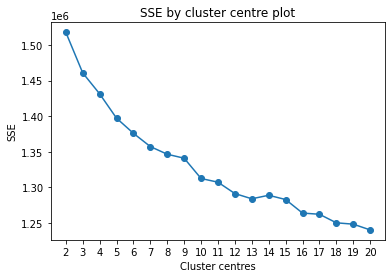

In [25]:
find_optimal_clusters(embeddings, 20)

Place where highest fall in SSE occurs is the most optimal cluster. This means, in our case optimal cluster size is 2

In [27]:
clusters_2 = MiniBatchKMeans(n_clusters=2, init_size=1024, batch_size=2048, random_state=20).fit_predict(embeddings)

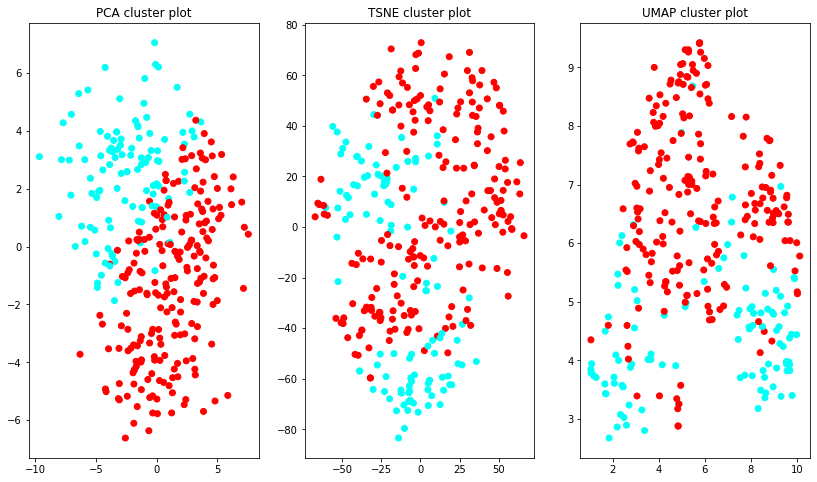

In [28]:
def plot_tsne_pca_umap(df, labels):
    max_label = max(labels) + 1
    max_items = np.random.choice(range(df.shape[0]), size=3000, replace=False)
    reducer = umap.UMAP()
    pca = PCA(n_components=2).fit_transform(df[max_items, :])
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(df[max_items, :]))
    uma = reducer.fit_transform(PCA(n_components=50).fit_transform(df[max_items, :]))

    idx = np.random.choice(range(pca.shape[0]), size=320, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]

    f, ax = plt.subplots(1, 3, figsize=(14,8))
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title("PCA cluster plot")
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title("TSNE cluster plot")
    ax[2].scatter(uma[idx, 0], uma[idx, 1], c=label_subset)
    ax[2].set_title("UMAP cluster plot")

plot_tsne_pca_umap(embeddings, clusters_2)

In [29]:
clusters_3 = MiniBatchKMeans(n_clusters=3, init_size=1024, batch_size=2048, random_state=20).fit_predict(embeddings)

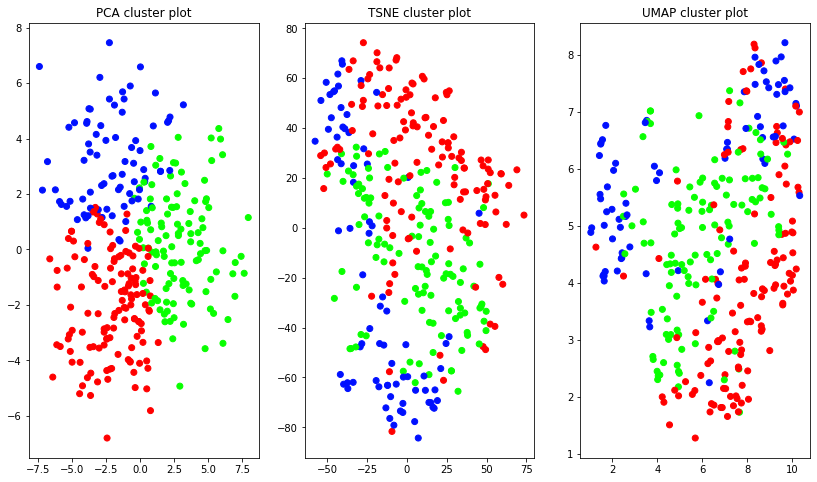

In [31]:
plot_tsne_pca_umap(embeddings, clusters_3)

In [34]:
topic_model.visualize_topics()

In [35]:
topic_model.visualize_distribution(probabilities[0])